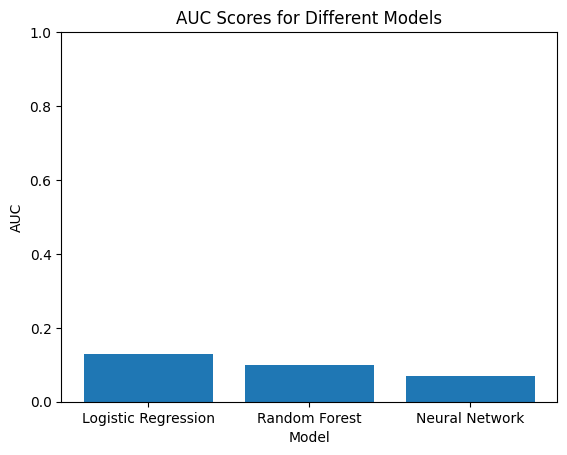

Evaluation Metrics:
Logistic Regression:
  AUC: 0.1291
  Accuracy: 0.7437
  F1 Score: 0.1818
  Recall: 0.7353

Random Forest:
  AUC: 0.1170
  Accuracy: 0.9294
  F1 Score: 0.1389
  Recall: 0.1471

Neural Network:
  AUC: 0.0655
  Accuracy: 0.9009
  F1 Score: 0.1386
  Recall: 0.2059



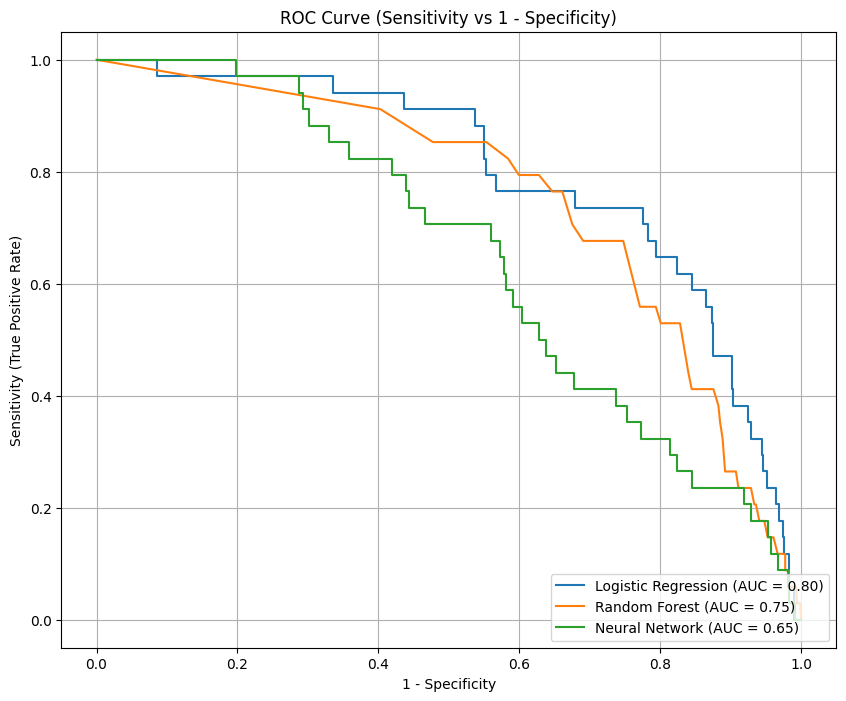

Number of Positive (Stroke) Cases: 165
Number of Negative (No Stroke) Cases: 4223
Number of samples synthesized by SMOTE: 6758
Number of positive case samples synthesized by SMOTE: 3379


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_curve, auc, accuracy_score, f1_score, recall_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load the dataset
brain_stroke = pd.read_csv('brain_stroke.csv')

# Encoding categorical variables
label_encoders = {}
for col in ['gender', 'work_type', 'Residence_type', 'smoking_status']:
    label_encoders[col] = LabelEncoder()
    brain_stroke[col] = label_encoders[col].fit_transform(brain_stroke[col])

# Convert binary variables to integers
binary_cols = ['hypertension', 'heart_disease']
for col in binary_cols:
    brain_stroke[col] = brain_stroke[col].astype(int)

# Convert 'ever_married' to binary
brain_stroke['ever_married'] = (brain_stroke['ever_married'] == 'Yes').astype(int)

# Removing outliers in numerical variables using IQR method
def remove_outliers(df, cols):
    for col in cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

numerical_cols = ['age', 'avg_glucose_level', 'bmi']
brain_stroke = remove_outliers(brain_stroke, numerical_cols)

# Splitting the dataset into features and target variable
X = brain_stroke.drop(columns=['stroke'])
y = brain_stroke['stroke']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier(max_iter=1000)
}

# Train models and calculate AUC based on precision-recall curve
auc_scores = {}
for name, model in models.items():
    model.fit(X_resampled, y_resampled)
    if name == 'Neural Network':
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    auc_score = auc(recall, precision)
    auc_scores[name] = auc_score

# Plot AUC scores
plt.bar(auc_scores.keys(), auc_scores.values())
plt.xlabel('Model')
plt.ylabel('AUC')
plt.title('AUC Scores for Different Models')
plt.ylim(0, 1)
plt.show()

# Train models and calculate additional evaluation metrics
auc_scores = {}
accuracy_scores = {}
f1_scores = {}
recall_scores = {}

for name, model in models.items():
    model.fit(X_resampled, y_resampled)
    if name == 'Neural Network':
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    auc_score = auc(recall, precision)
    auc_scores[name] = auc_score

    y_pred = model.predict(X_test)
    accuracy_scores[name] = accuracy_score(y_test, y_pred)
    f1_scores[name] = f1_score(y_test, y_pred)
    recall_scores[name] = recall_score(y_test, y_pred)

# Print evaluation metrics
print("Evaluation Metrics:")
for name in models.keys():
    print(f"{name}:")
    print(f"  AUC: {auc_scores[name]:.4f}")
    print(f"  Accuracy: {accuracy_scores[name]:.4f}")
    print(f"  F1 Score: {f1_scores[name]:.4f}")
    print(f"  Recall: {recall_scores[name]:.4f}")
    print()

# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, model in models.items():
    if name == 'Neural Network':
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = auc(fpr, tpr)
    plt.plot(1 - fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('ROC Curve (Sensitivity vs 1 - Specificity)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Count positive and negative cases
stroke_counts = brain_stroke['stroke'].value_counts()

# Print the counts
print("Number of Positive (Stroke) Cases:", stroke_counts[1])
print("Number of Negative (No Stroke) Cases:", stroke_counts[0])

num_samples_synthesized = X_resampled.shape[0]

print("Number of samples synthesized by SMOTE:", num_samples_synthesized)

# Count the number of positive case samples produced by SMOTE
num_positive_samples_synthesized = sum(y_resampled == 1)

print("Number of positive case samples synthesized by SMOTE:", num_positive_samples_synthesized)
